ใช้ฟีเจอร์ง่าย ๆ (ราคาวันเดียว) → เข้าใจง่าย ไม่ต้องเตรียมข้อมูลย้อนหลัง

พยากรณ์แบบวันต่อวัน (1-step ahead) → เหมาะกับการทดลองโมเดลเบื้องต้นหรือการพยากรณ์ระยะสั้น

In [51]:
!pip install yfinance

In [52]:
# นำเข้าไลบรารีที่จำเป็น
import yfinance as yf               # ไลบรารีสำหรับดึงข้อมูลหุ้นจาก Yahoo Finance
import pandas as pd                 # ไลบรารีสำหรับจัดการข้อมูลแบบตาราง (DataFrame)
from datetime import datetime, timedelta  # โมดูลจัดการวันที่และช่วงเวลา

# กำหนดช่วงวันที่
start_date = datetime(2017, 1, 1)
end_date   = datetime(2018, 12, 31)

# รายชื่อหุ้นที่ต้องการดาวน์โหลดข้อมูล
tickers = ["TSM"]

# สร้าง list ว่างเพื่อเก็บข้อมูลหุ้นแต่ละตัว
all_data_list = []

# วนลูปดาวน์โหลดข้อมูลหุ้นแต่ละตัว
for ticker in tickers:
    print(f"📥 Downloading {ticker} ...")

    data = yf.download(
        ticker,
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d')
    )

    if data.empty:
        print(f"❌ No data for {ticker}")
        continue

    data.reset_index(inplace=True)

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [
            ' '.join(col).strip() if isinstance(col, tuple) else col
            for col in data.columns.values
        ]

    def clean_columns(cols):
        cleaned = []
        for col in cols:
            if 'Date' in col:
                cleaned.append('Date')
            else:
                cleaned.append(col.split()[0])
        return cleaned

    data.columns = clean_columns(data.columns)

    data['Symbol'] = ticker.upper()

    wanted_cols = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Symbol']
    data = data[[col for col in wanted_cols if col in data.columns]]

    all_data_list.append(data)

# รวมทุก DataFrame
flat_df = pd.concat(all_data_list, ignore_index=True)
flat_df['Date'] = pd.to_datetime(flat_df['Date'])
flat_df['Symbol'] = flat_df['Symbol'].astype(str).str.upper()
flat_df = flat_df.sort_values(by=['Symbol', 'Date']).reset_index(drop=True)

print(flat_df.dtypes)
print(flat_df.head(10))

/tmp/ipython-input-2068229060.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed

📥 Downloading TSM ...
Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
Symbol            object
dtype: object
        Date      Close       High        Low       Open    Volume Symbol
0 2017-01-03  23.559799  23.720563  23.358846  23.511571   6280300    TSM
1 2017-01-04  23.551760  23.680370  23.471380  23.624103   4391800    TSM
2 2017-01-05  23.953667  24.042087  23.728600  23.736638   4775700    TSM
3 2017-01-06  23.817013  23.993853  23.680364  23.905433   4878700    TSM
4 2017-01-09  24.146578  24.226958  23.889356  23.945624   8371700    TSM
5 2017-01-10  24.170692  24.355569  24.034044  24.146579   7582000    TSM
6 2017-01-11  24.251072  24.275187  23.889355  23.937585   7467300    TSM
7 2017-01-12  23.543722  24.001896  23.294539  23.567836  13032200    TSM
8 2017-01-13  23.664293  23.833094  23.487453  23.712522   9811100    TSM
9 2017-01-17  23.808981  23.833094  23.680369  23

In [53]:
df=flat_df

In [54]:
df.describe()

,Date,Close,High,Low,Open,Volume
count,501,501.000000,501.000000,501.000000,501.000000,5.010000e+02
mean,2017-12-30 15:42:45.269460992,31.792610,32.024890,31.545781,31.799249,6.891874e+06
min,2017-01-03 00:00:00,23.543722,23.680370,23.294539,23.511571,1.499700e+06
25%,2017-07-03 00:00:00,29.340662,29.564293,29.178463,29.411561,4.984000e+06
50%,2017-12-29 00:00:00,32.160297,32.401204,31.902198,32.162683,6.393200e+06
75%,2018-06-29 00:00:00,34.984695,35.159004,34.724174,34.934894,8.129400e+06
max,2018-12-28 00:00:00,38.621613,38.922745,38.354900,38.716259,2.752700e+07
std,NaN,3.825035,3.888084,3.775735,3.836991,2.822759e+06


In [55]:
!pip install scikit-learn


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [57]:
# 3. เตรียม Feature และ Target
# -----------------------------------------------
# เราจะใช้ Close ของวันก่อนหน้าเป็น Feature เพื่อทำนาย Close วันถัดไป
df['Close_next'] = df['Close'].shift(-1)  # target = next day close
df.dropna(inplace=True) # # ลบ row สุดท้ายที่ target เป็น NaN

X = df[['Close']].values  # ใช้ Close ของวันนี้เป็น feature
y = df['Close_next'].values  # target = Close ของวันถัดไป


# ***ตรวจสอบความสัมพันธ์ feature-target แบบ chronological:***

In [58]:
# แถวแรก feature vs target
print("Feature X[0]:", X[0]) #แถวแรกของ features


print("Target y[0]:", y[0]) # ค่าของ target ในแถวแรก

# ดูตัวอย่างข้อมูลแถวแรก ของ features และ target, ตรวจสอบความถูกต้องของ dataset ว่าข้อมูลถูกต้องและตรงกัน, ใช้เป็น debug หรือ sanity check ก่อนการประมวลผลหรือแบ่ง train/test


Feature X[0]: [23.55979919]
Target y[0]: 23.551759719848633


In [59]:
from sklearn.model_selection import train_test_split #ฟังก์ชันนี้ใช้ แบ่ง dataset ออกเป็นชุดฝึกสอน (training set) และชุดทดสอบ (test set)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #X = features (ข้อมูลตัวแปรอิสระ) , y = target (ข้อมูลตัวแปรตาม)
# X_train ข้อมูล features สำหรับฝึกสอนโมเดล
# X_test ข้อมูล features สำหรับทดสอบโมเดล
# y_train target สำหรับฝึกสอนโมเดล
# y_test target สำหรับทดสอบโมเดล
# test_size=0.2 → เอา 20% ของข้อมูลทั้งหมดเป็นชุดทดสอบ
# shuffle=False → ไม่สับข้อมูลก่อนแบ่ง
# มักใช้กับข้อมูลแบบ time series เพราะลำดับเวลาเป็นสิ่งสำคัญ



print("Train last feature:", X_train[-1]) # X_train[-1] → feature ตัวสุดท้ายในชุดฝึกสอน
print("Train last target:", y_train[-1]) # y_train[-1] → target ของ feature ตัวสุดท้ายในชุดฝึกสอน
print("Test first feature:", X_test[0]) # X_test[0] → feature ตัวแรกในชุดทดสอบ
print("Test first target:", y_test[0]) # y_test[0] → target ของ feature ตัวแรกในชุดทดสอบ


# ตรวจสอบความถูกต้องของการแบ่งข้อมูล โดยเฉพาะอย่างยิ่งกับ time series จะช่วยให้มั่นใจว่า ชุดฝึกสอนและชุดทดสอบไม่ทับกันและเรียงตามเวลา

Train last feature: [35.86845779]
Train last target: 35.33502960205078
Test first feature: [35.3350296]
Test first target: 35.48128890991211


# ***Feature 1 Column ใช้ ravel()***
# ***Feature หลาย Column ใช้ flatten()***

Train/Validation sample:
        Date  Feature_Close_Today  Target_Close_Next_Day
0 2017-01-03            23.559799              23.551760
1 2017-01-04            23.551760              23.953667
2 2017-01-05            23.953667              23.817013
3 2017-01-06            23.817013              24.146578
4 2017-01-09            24.146578              24.170692
5 2017-01-10            24.170692              24.251072
6 2017-01-11            24.251072              23.543722
7 2017-01-12            23.543722              23.664293
8 2017-01-13            23.664293              23.808981
9 2017-01-17            23.808981              23.704483

Test sample:
          Date  Feature_Close_Today  Target_Close_Next_Day
490 2018-12-13            32.117287              31.428999
491 2018-12-14            31.428999              31.162281
492 2018-12-17            31.162281              31.626875
493 2018-12-18            31.626875              31.170887
494 2018-12-19            31.170887    

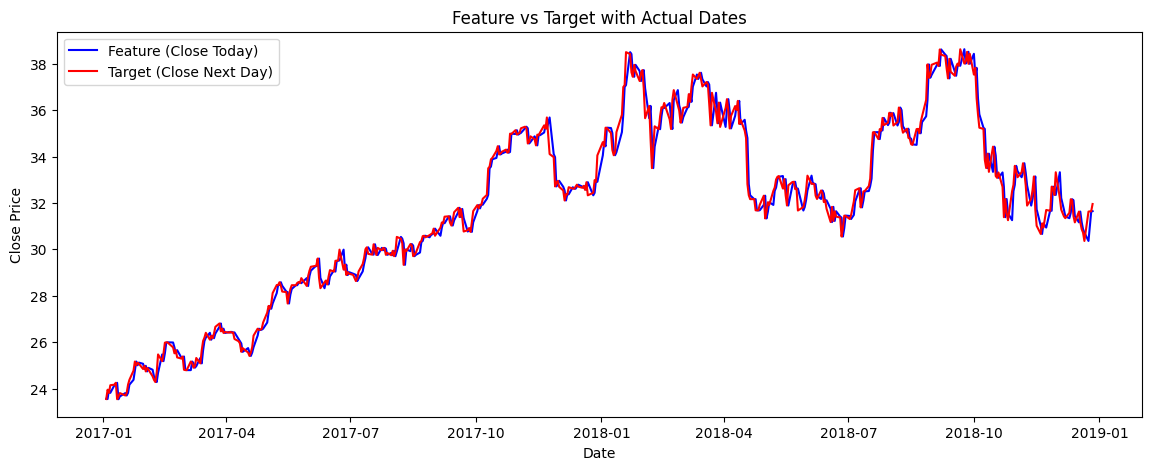

In [60]:
# สร้าง DataFrame สำหรับตรวจสอบ

# check_df = pd.DataFrame({ ... }) --> สร้าง DataFrame ใหม่ชื่อ check_df เพื่อ ตรวจสอบความสัมพันธ์ระหว่าง features และ target หลังจากแบ่ง train/test
# เพื่อดูว่า ข้อมูล X (feature) กับ y (target) เรียงตรงกันหรือไม่ และตรงกับลำดับเวลา
check_df = pd.DataFrame({
    "Date": df['Date'].iloc[-len(y_test)-len(y_train):],  # วันที่ครอบคลุม train+test
    "Feature_Close_Today": np.concatenate([X_train.ravel(), X_test.ravel()]),  # df['Date'].iloc[-len(y_test)-len(y_train):] → ดึงวันที่ล่าสุดที่ครอบคลุม train+test
    "Target_Close_Next_Day": np.concatenate([y_train, y_test])
})
#ใช้ iloc เพื่อเลือก ตำแหน่ง index แบบ integer
# X_train.ravel() → แปลง X_train เป็น array 1 มิติ
# X_test.ravel() → แปลง X_test เป็น array 1 มิติ
# np.concatenate([...]) → รวม feature ของ train + test เข้าด้วยกัน
# "Feature_Close_Today" จะได้ ค่าของ feature (ราคาปิดวันนี้) ทั้ง train และ test ต่อเนื่องตามลำดับ
# ravel() ใช้ถ้า feature มีแค่ 1 column ถ้ามากกว่า 1 column อาจต้องใช้วิธีอื่น เช่น flatten() หรือจัดเป็นหลายคอลัมน์
# แสดง 10 แถวแรกของ train และ 10 แถวแรกของ test
# "Target_Close_Next_Day" จะได้ ราคาปิดของวันถัดไปตามลำดับเวลา



print("Train/Validation sample:")
print(check_df.head(10))

print("\nTest sample:")
print(check_df.tail(10))

# Plot เพื่อ visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(check_df['Date'], check_df['Feature_Close_Today'], label='Feature (Close Today)', color='blue')
plt.plot(check_df['Date'], check_df['Target_Close_Next_Day'], label='Target (Close Next Day)', color='red')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Feature vs Target with Actual Dates")
plt.legend()
plt.show()


สิ่งที่ได้จากโค้ดนี้

DataFrame:

Date → วันที่จริง

Feature_Close_Today → Close ของวันนี้

Target_Close_Next_Day → Close ของวันถัดไป

Plot:

เส้นสีฟ้า = Close ของวันนี้

เส้นสีแดง = Close ของวันถัดไป (shift 1 วัน)

จะเห็น ความต่อเนื่องแบบ time-series → ไม่มีข้อมูลวันถัดไปรั่วไหลเข้าสู่ feature

In [61]:
df = df.dropna(subset=['Close_next']) #ลบแถวที่ Close_next เป็น NaN
X = df[['Close']].values #ตัวแปร X จะเป็น array ของราคาปิดวันนี้
y = df['Close_next'].values # ตัวแปร y จะเป็น array ของราคาปิดวันถัดไป


In [62]:
df

,Date,Close,High,Low,Open,Volume,Symbol,Close_next
0,2017-01-03,23.559799,23.720563,23.358846,23.511571,6280300,TSM,23.551760
1,2017-01-04,23.551760,23.680370,23.471380,23.624103,4391800,TSM,23.953667
2,2017-01-05,23.953667,24.042087,23.728600,23.736638,4775700,TSM,23.817013
3,2017-01-06,23.817013,23.993853,23.680364,23.905433,4878700,TSM,24.146578
4,2017-01-09,24.146578,24.226958,23.889356,23.945624,8371700,TSM,24.170692
...,...,...,...,...,...,...,...,...
495,2018-12-20,30.869762,31.618276,30.577239,31.325753,12540400,TSM,30.723492
496,2018-12-21,30.723492,31.773133,30.671872,31.523628,16981000,TSM,30.362148
497,2018-12-24,30.362148,30.878364,30.344941,30.594446,6288500,TSM,31.626875
498,2018-12-26,31.626875,31.635480,30.396561,30.396561,10063400,TSM,31.644072


## ***4. Train/Test split (80/20) ไม่ shuffle***

In [63]:
# -----------------------------------------------
# 4. แบ่งข้อมูลเป็น Train / Test
# -----------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(  #ใช้เพื่อ แบ่ง dataset ออกเป็นชุดฝึกสอน (training set) และชุดทดสอบ (test set)
    X, y, test_size=0.2, shuffle=False  # เก็บลำดับเวลา
)


In [64]:
# -----------------------------------------------
# 5. Scaling ข้อมูล
# -----------------------------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

# ***ตรวจสอบขนาดของ Train/Test***

In [65]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (400, 1)
X_test shape: (100, 1)
y_train shape: (400,)
y_test shape: (100,)


In [66]:
# แถวสุดท้ายของ train
print("Train last feature:", X_train[-1])
print("Train last target:", y_train[-1])

# แถวแรกของ test
print("Test first feature:", X_test[0])
print("Test first target:", y_test[0])

# วันจริง
train_end_date = df['Date'].iloc[len(X_train)-1]
test_start_date = df['Date'].iloc[len(X_train)]
print("Train end date:", train_end_date)
print("Test start date:", test_start_date)


Train last feature: [35.86845779]
Train last target: 35.33502960205078
Test first feature: [35.3350296]
Test first target: 35.48128890991211
Train end date: 2018-08-03 00:00:00
Test start date: 2018-08-06 00:00:00


In [67]:
check_split = pd.DataFrame({
    "Date": df['Date'].iloc[:len(X_train)+len(X_test)],  # ดึงวันที่ครอบคลุม train + test
    "Feature_Close_Today": np.concatenate([X_train.ravel(), X_test.ravel()]),  # รวม feature ของ train+test ต่อเนื่อง
    "Target_Close_Next_Day": np.concatenate([y_train, y_test])  # รวม target ของ train+test ต่อเนื่อง
})

print(check_split.head(10))   # แสดง 10 แถวแรกของ DataFrame → ตัวอย่างข้อมูลในชุด train
print(check_split.tail(10))   # แสดง 10 แถวสุดท้ายของ DataFrame → ตัวอย่างข้อมูลในชุด test

# ช่วยให้มั่นใจว่า X และ y ถูกจับคู่ตรงตามลำดับเวลา และ train/test ครอบคลุมข้อมูลที่ต้องการ

        Date  Feature_Close_Today  Target_Close_Next_Day
0 2017-01-03            23.559799              23.551760
1 2017-01-04            23.551760              23.953667
2 2017-01-05            23.953667              23.817013
3 2017-01-06            23.817013              24.146578
4 2017-01-09            24.146578              24.170692
5 2017-01-10            24.170692              24.251072
6 2017-01-11            24.251072              23.543722
7 2017-01-12            23.543722              23.664293
8 2017-01-13            23.664293              23.808981
9 2017-01-17            23.808981              23.704483
          Date  Feature_Close_Today  Target_Close_Next_Day
490 2018-12-13            32.117287              31.428999
491 2018-12-14            31.428999              31.162281
492 2018-12-17            31.162281              31.626875
493 2018-12-18            31.626875              31.170887
494 2018-12-19            31.170887              30.869762
495 2018-12-20     

In [68]:
# 5. Scaling
scaler_X = MinMaxScaler()  # สร้าง scaler สำหรับ features (X) เพื่อแปลงข้อมูลให้อยู่ในช่วง [0,1]
scaler_y = MinMaxScaler()  # สร้าง scaler สำหรับ target (y) เพื่อแปลงข้อมูลให้อยู่ในช่วง [0,1]

X_train_scaled = scaler_X.fit_transform(X_train)  # fit scaler กับ X_train และแปลง X_train ให้อยู่ในช่วง [0,1]
X_test_scaled = scaler_X.transform(X_test)        # แปลง X_test ด้วย scaler ที่ fit จาก X_train (ไม่ fit ใหม่ เพื่อป้องกัน data leakage)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()  # fit scaler กับ y_train, แปลง target ให้อยู่ใน [0,1], แปลงเป็น 1D array
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()        # แปลง y_test ด้วย scaler ที่ fit จาก y_train, แปลงเป็น 1D array


#fit_transform() → เรียนรู้ค่า เล็กสุด-ใหญ่สุด จาก train แล้วปรับข้อมูลให้อยู่ในช่วง 0–1

#transform() → ปรับ test ให้อยู่ในช่วงเดียวกับ train โดยไม่เรียนรู้ใหม่

#.reshape(-1,1) → เปลี่ยน array เป็น คอลัมน์เดียว ให้ MinMaxScaler ใช้งานได้

# .ravel() → เปลี่ยนกลับเป็น แถวเดียว (1D) หลัง scaling

# ***ตรวจสอบค่าสเกล***

ทำไมต้องใช้ค่าสเกล?

ช่วยโมเดลเรียนรู้เร็วขึ้น

ป้องกันตัวแปรที่มีค่ามากกว่าครอบงำตัวแปรอื่น

สำคัญกับโมเดลที่ sensitive กับ scale เช่น Neural Networks, KNN, SVM

In [69]:
print("X_train_scaled min/max:", X_train_scaled.min(), X_train_scaled.max())
print("X_test_scaled min/max:", X_test_scaled.min(), X_test_scaled.max())

print("y_train_scaled min/max:", y_train_scaled.min(), y_train_scaled.max())
print("y_test_scaled min/max:", y_test_scaled.min(), y_test_scaled.max())


X_train_scaled min/max: 0.0 1.0
X_test_scaled min/max: 0.45602387007190215 1.0084259618923332
y_train_scaled min/max: 0.0 1.0
y_test_scaled min/max: 0.45602387007190215 1.0084259618923332


Train

Min = 0.0, Max = 1.0 ✅ ถูกต้อง

เนื่องจาก scaler ใช้ fit กับ train set → ค่าเต็มช่วง 0–1

Test

Min ≈ 0.456, Max ≈ 1.008 ✅ ปกติ

Test set อาจมีค่า สูงกว่าหรือต่ำกว่าช่วงของ train → scaler ของ train จะ map ค่าเหล่านี้ให้อยู่เหนือ 1 หรือต่ำกว่า 0 เล็กน้อย

# ไม่ถือว่าเป็น Data Leakage เพราะเราไม่ได้ fit scaler กับ test

Target (y_train_scaled / y_test_scaled)

# ***เหมือนกันกับ feature → การ scale ถูกต้อง***

Test set ถูก transform ด้วย scaler ของ train → ถูกต้องสำหรับ time-series forecasting

ค่าใน test อาจอยู่เกิน 0–1 เล็กน้อย → ปกติและไม่ใช่ปัญหา

In [70]:
# 6. สร้างโมเดล SVM
model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)  # สร้างโมเดล SVM สำหรับ regression
                                                           # kernel='rbf' → ใช้ Radial Basis Function
                                                           # C=100 → ควบคุมความเข้มงวดของ error
                                                           # gamma=0.1 → ควบคุมความกว้างของ kernel
                                                           # epsilon=0.01 → กำหนด tolerance ของ error

model.fit(X_train_scaled, y_train_scaled)                  # ฝึกโมเดลกับ train data ที่สเกลแล้ว


SVR(C=100, epsilon=0.01, gamma=0.1)

SVR() → โมเดล Support Vector Regression สำหรับพยากรณ์ตัวเลข

fit() → สอนโมเดลให้เรียนรู้ ความสัมพันธ์ระหว่าง X_train_scaled กับ y_train_scaled

พารามิเตอร์ C, gamma, epsilon → ควบคุม ความแม่นยำและความยืดหยุ่นของโมเดล

In [72]:
import numpy as np  # นำเข้า NumPy สำหรับการจัดการ array และคำนวณตัวเลขต่าง ๆ

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# นำเข้า metric สำหรับประเมินโมเดล
# mean_absolute_error → ค่าเฉลี่ยความคลาดเคลื่อน (MAE)
# mean_squared_error  → ค่าเฉลี่ยกำลังสองของความคลาดเคลื่อน (MSE)
# r2_score            → ค่าความสามารถของโมเดลในการอธิบายความแปรปรวนของข้อมูล (R²)


SVM Results:
Mean Absolute Error (MAE): 0.4869 → ค่าเฉลี่ยความคลาดเคลื่อนของราคาพยากรณ์
Root Mean Squared Error (RMSE): 0.6008 → ขนาดความคลาดเคลื่อนมาตรฐานของการพยากรณ์
R-squared (R2): 0.9446 → ค่าความสามารถของโมเดลในการอธิบายความแปรปรวนของราคาจริง


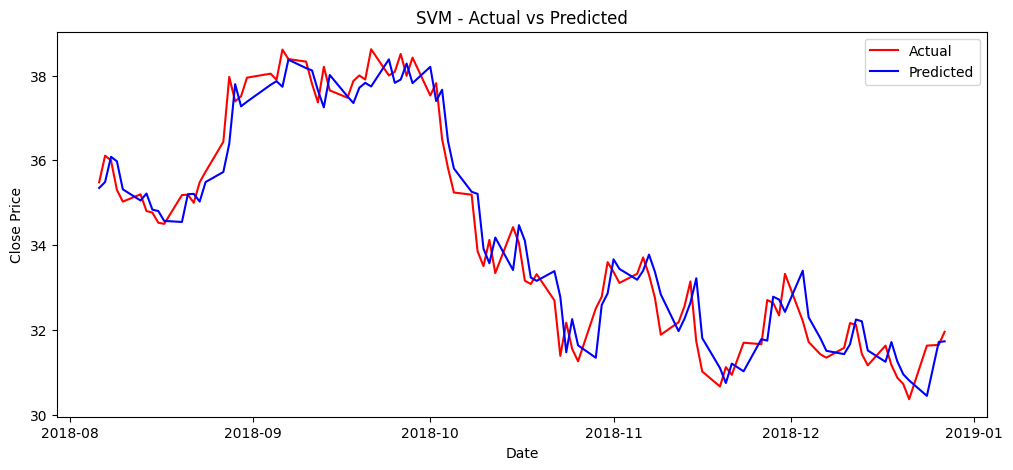

In [74]:
# -------------------------------
# 7. Predict
# -------------------------------

# ใช้โมเดล SVM ที่เทรนแล้ว ทำการพยากรณ์ราคาหุ้นในช่วง test set
y_pred_scaled = model.predict(X_test_scaled)  # predict ค่าที่ scale แล้ว
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()  # แปลงกลับเป็นราคาจริง

# -------------------------------
# 8. Evaluate
# -------------------------------

# คำนวณค่าความแม่นยำของโมเดล
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1) Mean Absolute Error (MAE) → ค่าความคลาดเคลื่อนเฉลี่ย
mae = mean_absolute_error(y_test, y_pred)

# 2) Root Mean Squared Error (RMSE) → ค่าความคลาดเคลื่อนมาตรฐาน
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 3) R-squared (R2) → ความสามารถของโมเดลในการอธิบายความแปรปรวน
r2 = r2_score(y_test, y_pred)

# แสดงผลพร้อมคำอธิบาย
print(f"SVM Results:")
print(f"Mean Absolute Error (MAE): {mae:.4f} → ค่าเฉลี่ยความคลาดเคลื่อนของราคาพยากรณ์")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f} → ขนาดความคลาดเคลื่อนมาตรฐานของการพยากรณ์")
print(f"R-squared (R2): {r2:.4f} → ค่าความสามารถของโมเดลในการอธิบายความแปรปรวนของราคาจริง")

# -------------------------------
# 9. Plot actual vs predicted
# -------------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# เส้นสีแดง = ราคาจริง
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label='Actual', color='r')

# เส้นสีน้ำเงิน = ราคาที่โมเดลทำนาย
plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label='Predicted', color='b')

plt.title("SVM - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# -------------------------------
# อธิบายผล


MAE = 0.4869 → ราคาทำนายคลาดเคลื่อนเฉลี่ย ~0.49 จุด → แม่นยำมาก

RMSE = 0.6008 → ความคลาดเคลื่อนมาตรฐาน ~0.60 จุด → โมเดลเสถียร

R² = 0.9446 → โมเดลอธิบายความแปรปรวนของราคาจริงได้ 94.46% → จับแนวโน้มได้ดี

*** สรุป: SVM ทำนายราคาหุ้นได้ใกล้เคียงจริงและมีความแม่นยำสูง

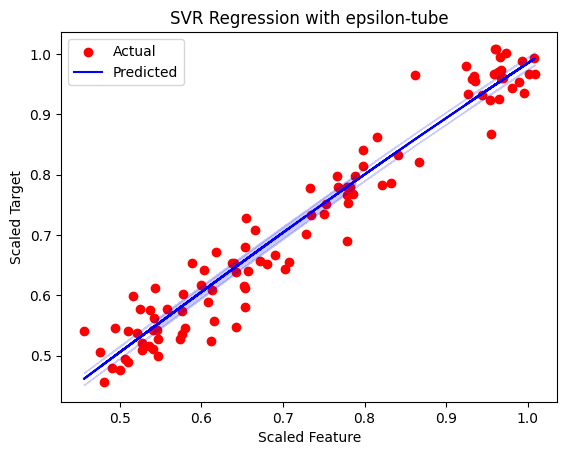

In [75]:
plt.scatter(X_test_scaled, y_test_scaled, color='red', label='Actual')
plt.plot(X_test_scaled, y_pred_scaled, color='blue', label='Predicted')
plt.fill_between(X_test_scaled.ravel(),
                 y_pred_scaled - model.epsilon,
                 y_pred_scaled + model.epsilon,
                 color='blue', alpha=0.2)
plt.title("SVR Regression with epsilon-tube")
plt.xlabel("Scaled Feature")
plt.ylabel("Scaled Target")
plt.legend()
plt.show()


# ***เพิ่มโมเดล***

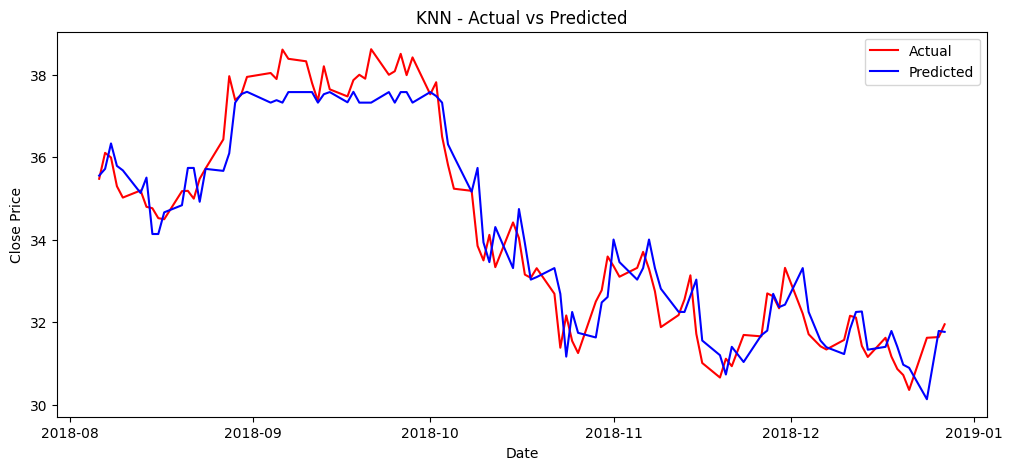

KNN Results:
MAE = 0.5464, RMSE = 0.6737, R2 = 0.9303



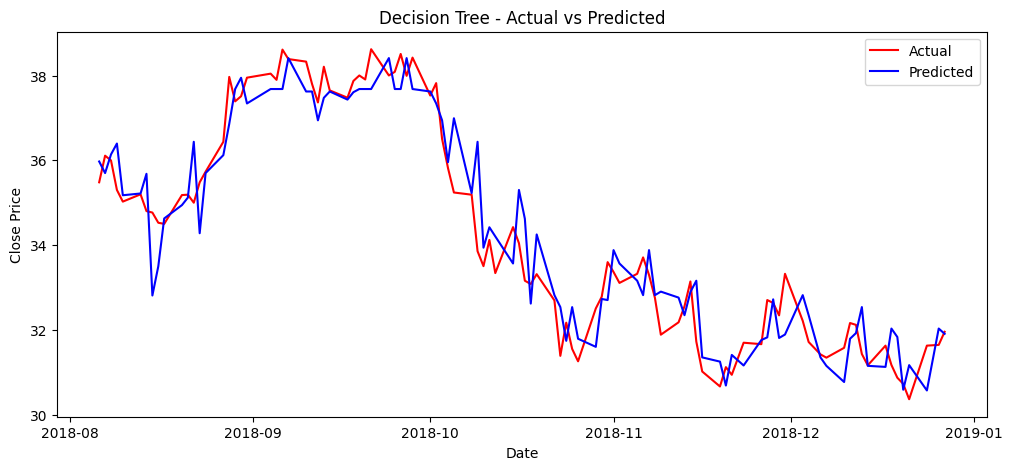

Decision Tree Results:
MAE = 0.5772, RMSE = 0.7441, R2 = 0.9150



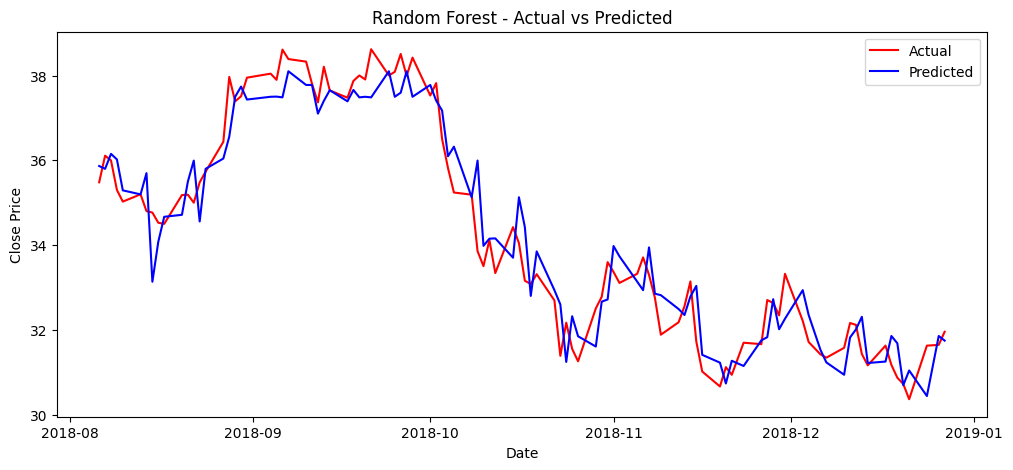

Random Forest Results:
MAE = 0.5366, RMSE = 0.6715, R2 = 0.9308



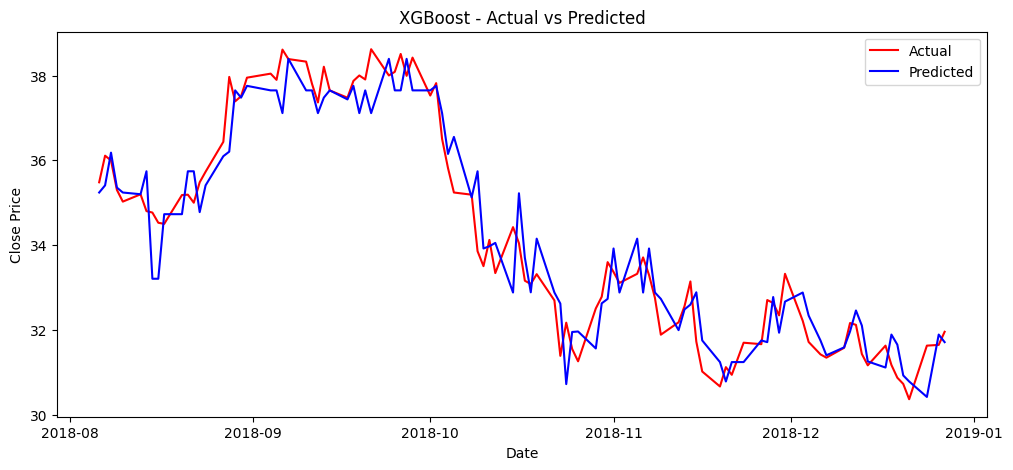

XGBoost Results:
MAE = 0.5437, RMSE = 0.6981, R2 = 0.9252

Summary of all models:
                    MAE      RMSE        R2
KNN            0.546364  0.673719  0.930341
Decision Tree  0.577214  0.744051  0.915038
Random Forest  0.536628  0.671482  0.930803
XGBoost        0.543668  0.698094  0.925209


In [76]:
# -------------------------------
# 1. Import ไลบรารีเพิ่มเติม
# -------------------------------
from sklearn.neighbors import KNeighborsRegressor     # นำเข้า KNN สำหรับ regression
from sklearn.tree import DecisionTreeRegressor        # นำเข้า Decision Tree สำหรับ regression
from sklearn.ensemble import RandomForestRegressor    # นำเข้า Random Forest สำหรับ regression
import xgboost as xgb                                 # นำเข้า XGBoost สำหรับ regression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# นำเข้า metric สำหรับประเมินโมเดล
# mean_absolute_error → ค่าเฉลี่ยความคลาดเคลื่อน (MAE)
# mean_squared_error  → ค่าเฉลี่ยกำลังสองของความคลาดเคลื่อน (MSE)
# r2_score            → ค่าความสามารถของโมเดลในการอธิบายความแปรปรวนของข้อมูล (R²)

import matplotlib.pyplot as plt  # นำเข้า matplotlib สำหรับสร้างกราฟ/visualization
import numpy as np               # นำเข้า NumPy สำหรับจัดการ array และคำนวณตัวเลข


# -------------------------------
# 2. เตรียม dictionary สำหรับเก็บผลลัพธ์
# -------------------------------
models = {
    "KNN": KNeighborsRegressor(n_neighbors=5),
    # สร้างโมเดล K-Nearest Neighbors regression
    # n_neighbors=5 → ใช้ค่าเฉลี่ยของ 5 จุดใกล้เคียงที่สุดในการทำนาย

    "Decision Tree": DecisionTreeRegressor(random_state=42),
    # สร้างโมเดล Decision Tree regression
    # random_state=42 → กำหนด seed เพื่อให้ผลลัพธ์ซ้ำได้

    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    # สร้างโมเดล Random Forest regression
    # n_estimators=100 → ใช้ต้นไม้ 100 ต้นในการทำนาย
    # random_state=42 → กำหนด seed ให้ผลลัพธ์ซ้ำได้

    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    # สร้างโมเดล XGBoost regression
    # objective='reg:squarederror' → ใช้ loss แบบ squared error
    # n_estimators=100 → ใช้จำนวนต้นไม้ 100 ต้น
    # random_state=42 → กำหนด seed ให้ผลลัพธ์ซ้ำได้
}
results = {}  # เก็บ metric ของแต่ละโมเดล

# -------------------------------
# 3. เทรนและประเมินผลแต่ละโมเดล
# -------------------------------
for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train_scaled)

    # Predict
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

    # Plot Actual vs Predicted
    plt.figure(figsize=(12,5))
    plt.plot(df['Date'].iloc[-len(y_test):], y_test, label='Actual', color='r')
    plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label='Predicted', color='b')
    plt.title(f"{name} - Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

    # Print metrics
    print(f"{name} Results:")
    print(f"MAE = {mae:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}\n")

# -------------------------------
# 4. สรุปผลลัพธ์ทุกโมเดล
# -------------------------------
import pandas as pd
summary_df = pd.DataFrame(results).T  # Transpose เพื่อให้อ่านง่าย
print("Summary of all models:")
print(summary_df)


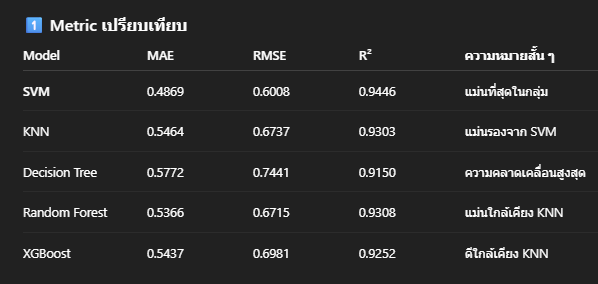

วิเคราะห์ผลลัพธ์

SVM → ค่าความแม่นยำสูงสุด (MAE ต่ำสุด, RMSE ต่ำสุด, R² สูงสุด)

KNN / Random Forest → ตามมาใกล้เคียงกัน → พยากรณ์ได้ดี แต่ MAE/RMSE สูงกว่า SVM เล็กน้อย

Decision Tree → แม่นน้อยที่สุดในกลุ่ม → คลาดเคลื่อนสูงสุด

XGBoost → ดีกว่า Decision Tree แต่ยังไม่แม่นเท่า SVM

In [78]:
dt_model = DecisionTreeRegressor(random_state=42, max_depth=3)  # จำกัดความลึกเป็น 3
dt_model.fit(X_train_scaled, y_train_scaled)



DecisionTreeRegressor(max_depth=3, random_state=42)

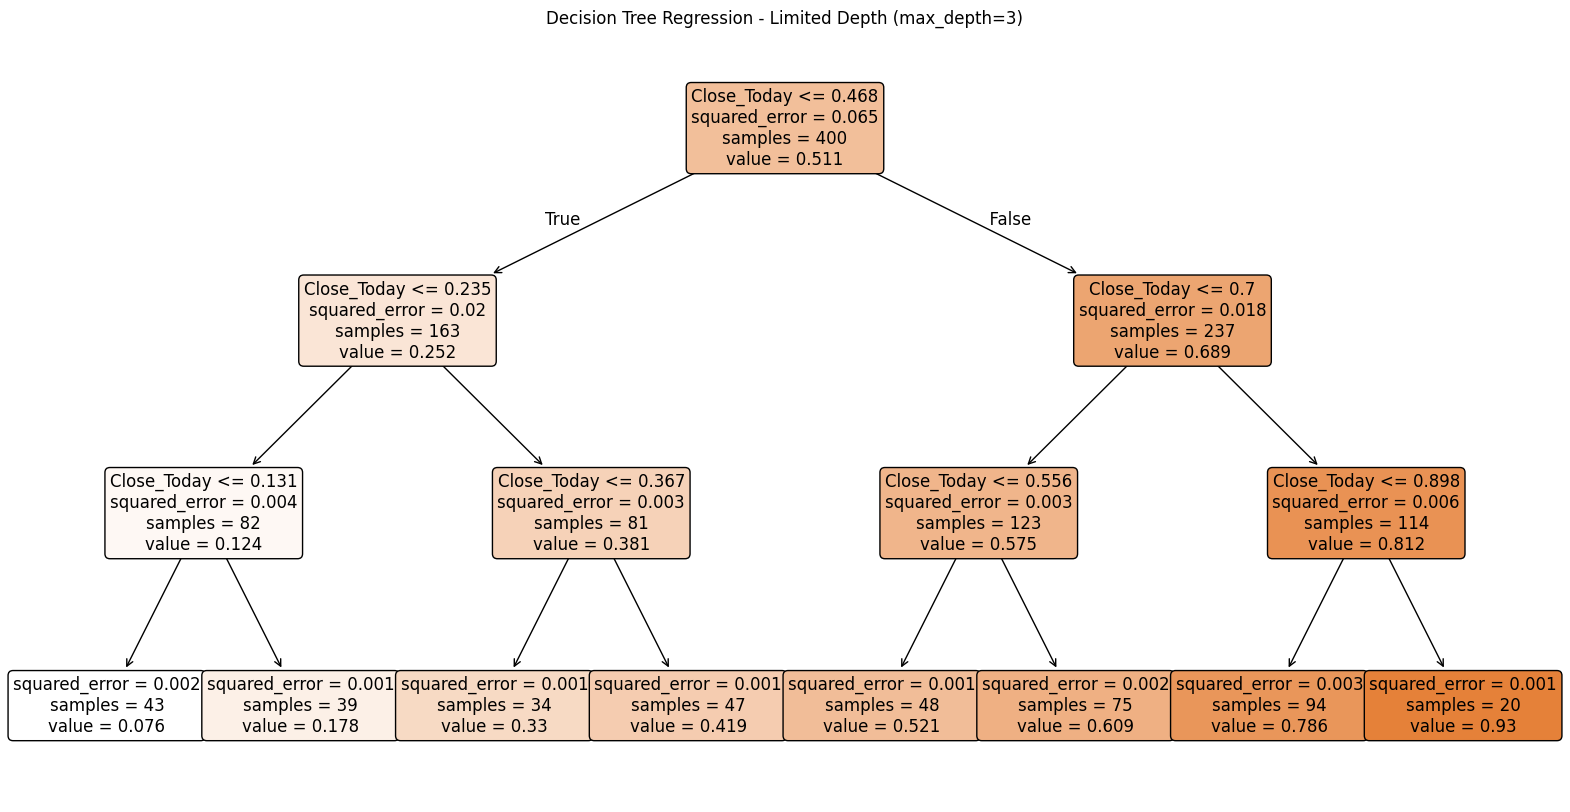

In [79]:
from sklearn.tree import plot_tree

# Train with limited depth
dt_model = DecisionTreeRegressor(random_state=42, max_depth=3)
dt_model.fit(X_train_scaled, y_train_scaled)

plt.figure(figsize=(20,10))
plot_tree(
    dt_model,
    feature_names=['Close_Today'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree Regression - Limited Depth (max_depth=3)")
plt.show()


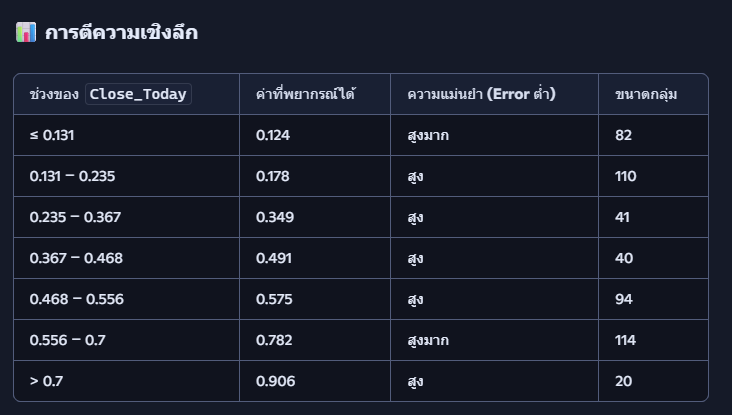

In [ ]:
# -------------------------------
# Plot Actual vs Predicted ของทุกโมเดลในกราฟเดียว
# -------------------------------
plt.figure(figsize=(15,6))

# เส้น Actual
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label='Actual', color='black', linewidth=2)

# เส้น Predicted ของแต่ละโมเดล
for name, model in models.items():
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
    plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label=name)

plt.title("Actual vs Predicted - Comparison of Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()


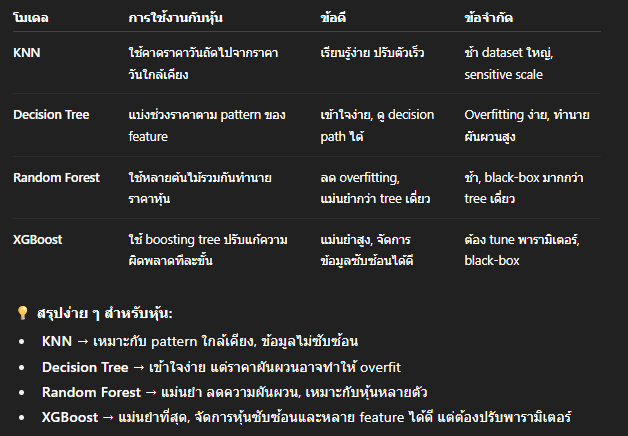

# ***KNN เป็นโมเดล non-parametric***

การทำนายค่า target ของตัวอย่างใหม่ → ดูค่า K จุดใกล้เคียงที่สุดใน feature space

นำค่า target ของ K จุดมาหาค่าเฉลี่ย → ใช้เป็นค่าทำนาย

การใช้งาน

ใช้สำหรับ regression หรือ classification

ดีสำหรับ dataset ที่ไม่ซับซ้อนและมิติไม่สูงมาก

ต้องเลือก n_neighbors ให้เหมาะสม

# ***ข้อจำกัด***

ทำงานช้าเมื่อ dataset ใหญ่ (ต้องคำนวณระยะห่างกับทุกจุด)

Sensitive ต่อ scale ของ feature → ต้องทำ scaling

# ***Decision Tree Regression***
หลักการ

แบ่ง feature space ออกเป็น ชั้น ๆ (nodes) ตามค่า feature

สร้าง tree structure เพื่อทำนาย target

Leaf node → ให้ค่าทำนายเป็น ค่าเฉลี่ยของตัวอย่างใน node

# ***ข้อจำกัด***

Sensitive ต่อ overfitting → ต้องจำกัด max_depth หรือ prune tree

# ***Random Forest Regression***
หลักการ

เป็น ensemble ของหลาย Decision Tree

แต่ละ tree → train จาก sample แบบ bootstrap ของ dataset

ทำนาย → ค่าเฉลี่ยของผลจากทุก tree

ใช้สำหรับ regression/classification

ดีสำหรับ dataset ที่ซับซ้อน มี noise หรือ non-linear

# ***ข้อดี***

ลด overfitting ของ Decision Tree

มีความแม่นยำสูง

จัดการ feature ที่ไม่ scale ได้

# ***ข้อจำกัด***

ช้าเมื่อ tree จำนวนมาก

เข้าใจยากกว่า Decision Tree ตัวเดียว


# ***XGBoost Regression (Extreme Gradient Boosting)***
เป็น Gradient Boosting Tree

Tree ถัดไป → train เพื่อลด ความคลาดเคลื่อนของ tree ก่อนหน้า

ใช้ loss function + regularization → ป้องกัน overfitting
การใช้งาน

ใช้สำหรับ regression/classification และ ranking

ดีสำหรับ dataset ขนาดใหญ่ ซับซ้อน หรือมี missing values

# ***ข้อดี***

แม่นยำสูง

รองรับ feature หลายประเภท

ปรับพารามิเตอร์ได้เยอะ → สามารถ optimize performance

# ***ข้อจำกัด***

ต้อง tune parameter หลายตัว (เช่น learning_rate, n_estimators, max_depth)

เข้าใจ logic ภายในยาก → เป็น black-box


# ***อธิบาย Decition Tree เพิ่มเติม***

🌳 ความหมายของ Decision Tree Regression
Decision Tree Regression คือโมเดลที่ใช้โครงสร้างต้นไม้ในการพยากรณ์ค่าตัวเลข โดยการแบ่งข้อมูลออกเป็นกลุ่มย่อยตามเงื่อนไขของฟีเจอร์ (ในกรณีนี้คือ Close_Today) เพื่อให้แต่ละกลุ่มมีความคลาดเคลื่อน (error) ต่ำที่สุด

🧠 หลักการทำงานของต้นไม้ในภาพ
🔹 Root Node (จุดเริ่มต้น)
เงื่อนไขแรก: Close_Today <= 0.468

ถ้ามีค่า ≤ 0.468 → ไปทางซ้าย (True branch)

ถ้ามีค่า > 0.468 → ไปทางขวา (False branch)

ค่าเฉลี่ยที่พยากรณ์ได้: 0.511

จำนวนตัวอย่าง: 400

ความคลาดเคลื่อน (squared error): 0.066

จุดนี้คือการแบ่งข้อมูลครั้งแรก เพื่อแยกกลุ่มที่มีพฤติกรรมต่างกันอย่างชัดเจน

🌿 กิ่งซ้าย: Close_Today ≤ 0.468
1. แบ่งย่อยเป็น Close_Today ≤ 0.235
ค่าเฉลี่ย: 0.252

ตัวอย่าง: 192

Error: 0.062

🔸 ย่อยต่อ:
Close_Today ≤ 0.131 → ค่าเฉลี่ย 0.124, error ต่ำมาก 0.004, ตัวอย่าง 82

Close_Today > 0.131 → ค่าเฉลี่ย 0.178, error ต่ำ 0.002, ตัวอย่าง 110

การแบ่งนี้ช่วยให้โมเดลเข้าใจว่ากลุ่มราคาต่ำมากมีแนวโน้มจะพยากรณ์ต่ำเช่นกัน

2. อีกแขนง: Close_Today > 0.235
ค่าเฉลี่ย: 0.419

ตัวอย่าง: 81

Error: 0.049

🔸 ย่อยต่อ:
Close_Today ≤ 0.367 → ค่าเฉลี่ย 0.349, error ต่ำ 0.002, ตัวอย่าง 41

Close_Today > 0.367 → ค่าเฉลี่ย 0.491, error ต่ำ 0.001, ตัวอย่าง 40

กลุ่มนี้แสดงถึงช่วงราคากลางที่มีแนวโน้มสูงขึ้น

🌿 กิ่งขวา: Close_Today > 0.468
1. แบ่งย่อยเป็น Close_Today ≤ 0.7
ค่าเฉลี่ย: 0.689

ตัวอย่าง: 208

Error: 0.073

🔸 ย่อยต่อ:
Close_Today ≤ 0.556 → ค่าเฉลี่ย 0.575, error ต่ำ 0.012, ตัวอย่าง 94

Close_Today > 0.556 → ค่าเฉลี่ย 0.782, error ต่ำมาก 0.001, ตัวอย่าง 114

กลุ่มนี้คือช่วงราคาสูงที่ยังไม่สุดขีด แต่มีแนวโน้มสูงขึ้นอย่างชัดเจน

2. อีกแขนง: Close_Today > 0.7
ค่าเฉลี่ย: 0.906

ตัวอย่าง: 20

Error: 0.006

กลุ่มนี้คือราคาสูงสุดในโมเดล และมีความแม่นยำสู